In [1]:
import os
import gc
import time
import math
import datetime
from math import log, floor
from sklearn.neighbors import KDTree
import copy

import numpy as np
import modin.pandas as pd
from pathlib import Path
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm.notebook import tqdm as tqdm
from scipy.signal import find_peaks

import seaborn as sns
from matplotlib import colors
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

In [2]:
from lightgbm import LGBMRegressor
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

In [3]:
data = pd.read_csv('wtbdata_245days.csv')

To remove this warning, run the following python code before doing dataframe operations:

    import ray
    ray.init()



In [4]:
data = data[(data['Patv'].notnull()) & (data['Day']>180)]

In [5]:
def lag_feature(data, feat_columns, li):    
    # 在对应的位置设置lag列
    for shift_num in li:
        temp_data = data.groupby(['TurbID'])[feat_columns].shift(shift_num)
        temp_data.columns=[i+"_lag_"+str(shift_num) for i in feat_columns]
        data = pd.concat([data,temp_data],axis=1)
    return data 

In [6]:
def dataset_split(data):
    if 'Tmstamp' in data.columns.tolist():
        data = data.drop('Tmstamp',axis=1)
        
    train_data = data[lambda x: x.time_idx < 34993]
    val_data = data[(data.time_idx>=30816) & (data.time_idx < 34993)]
    test_data = data[lambda x: x.time_idx >= 34993]

    train_feat = train_data.drop('Patv',axis=1)
    train_label = train_data['Patv']
    val_feat = val_data.drop('Patv',axis=1)
    val_label = val_data['Patv']
    test_feat = test_data.drop('Patv',axis=1)
    test_label = test_data['Patv']
    test_individual_feat = []
    test_individual_label = []
    for i in range(data.TurbID.nunique()):
        tmp = test_data.drop('Patv',axis=1).loc[data['TurbID'] == i+1]
        tmp.columns = list(range(len(tmp.columns.tolist())))
        test_individual_feat.append(tmp)
        test_individual_label.append(test_data['Patv'].loc[data['TurbID'] == i+1])
    
    # 为了处理tsfresh的特殊符号列名，直接将所有列名写成数字
#     train_feat.columns = list(range(len(train_feat.columns.tolist())))
#     test_feat.columns = list(range(len(test_feat.columns.tolist())))
    
    return train_feat, train_label, val_feat, val_label, test_feat, test_label, test_individual_feat, test_individual_label

In [7]:
def lgb_test_new(gbm, data, test_feat, test_label, show=False):
    y_pred = gbm.predict(test_feat)
    patv_min = min(data.Patv)
    patv_max = max(data.Patv)
    for i in range(len(y_pred)):
        if y_pred[i] < 0:
            y_pred[i] = 0
        if y_pred[i] > patv_max:
            y_pred[i] = patv_max

    y_pred_clear = []
    test_label_clear = []
    for i in range(len(y_pred)):
#         if not (test_label.values[i] <= 0):
        y_pred_clear.append(y_pred[i])
        test_label_clear.append(test_label.values[i])
    
    
    # 模型评估
#     print('The rmse of prediction is:', mean_squared_error(test_label, y_pred) ** 0.5)
    pred_rmse = mean_squared_error(test_label_clear, y_pred_clear) ** 0.5
    print('The rmse of prediction is:', pred_rmse)

    # 模型评估
    pred_mae = mean_absolute_error(test_label_clear, y_pred_clear)
    print('The mae of prediction is:', pred_mae)

    # 特征重要度
#     print('{}\nFeature importances:{}'.format([column for column in test_feat], list(gbm.feature_importances_)))
    
    
    if show == True:
        plt.figure(figsize=(20,5))
        plt.plot(range(len(y_pred_clear)), y_pred_clear, label='pred')
        plt.plot(range(len(test_label_clear)), test_label_clear, label='label')
        plt.legend()
        plt.show()
    
    return y_pred_clear,pred_rmse,pred_mae

In [8]:
def get_test_feat(test_feat,test_label,time_idx):
    indexNames=test_feat[test_feat['time_idx'] !=time_idx].index
#     print(indexNames)
    test_feat = test_feat.drop(indexNames)
    test_label= test_label.drop(indexNames)
    return test_feat,test_label

In [9]:
def lag_insert(test_feat, num,index_list): #构造test集函数
    
    for j in range(1,num+1):
        
        time_idx_list = [m for m in range(34993,34993+j)]

        print(time_idx_list)

        feature_list = test_feat.columns[4+j -1:4+j]
        print(feature_list)


        for i in range(len(index_list)):
            for feature in feature_list:
                if test_feat.loc[index_list[i],'time_idx'] in time_idx_list:
                    test_feat.loc[index_list[i],feature] = data.loc[index_list[i]-j,'Patv']

                else:
                    test_feat.loc[index_list[i],feature] = np.nan

    return test_feat

In [10]:
def round_pred(gbm1,test_feat,test_label,pred_1,pred_list,rmse_list,mae_list,index_list): #循环预测函数
    
    for i in range(34994,34994+287):
        feature_list = test_feat.columns[4:]
        flag = 0
        for j in range(len(index_list)): #用预测的值填充lag1-n

            if test_feat.loc[index_list[j],'time_idx'] == i:

                for f in range(len(feature_list)):

                    if (index_list[j]+f) in index_list: #边界条件判断是否溢出

    #                     print(index_list[j]+flag)
                        test_feat.loc[index_list[j]+f,feature_list[f]] = pred_1[flag]

                flag += 1
#     print(exp_feat)
#     break;
        real_test_feat,real_test_label = get_test_feat(test_feat,test_label,i)
        print('predict:{}/288'.format(i-34993+1))
        pred_1,pred_rmse,pred_mae = lgb_test_new(gbm1, data, real_test_feat, real_test_label)
        print('----------------------------')
        pred_list.extend(pred_1)
        rmse_list.append(pred_rmse)
        mae_list.append(pred_mae)
    return pred_list,rmse_list,mae_list

In [11]:
lag_n = 50

# no_label feature_lag

In [12]:
feat_columns = ['Wspd','Wdir','Etmp','Itmp','Ndir','Pab1','Pab2','Pab3','Prtv']
li = [i for i in range(288,288+lag_n)]
data_lag1 = lag_feature(data, feat_columns, li)
data_lag1 = data_lag1[data_lag1['Prtv_lag_{}'.format(288+lag_n-1)].notnull()]

KeyboardInterrupt: 

# label lag

In [13]:
test_data = data_lag1[data_lag1['Day'].isin([244,245])]
real_test_data_patv = test_data.Patv.copy()
test_data.Patv = np.nan
train_data = data_lag1[data_lag1['Day']<244]
data_lag1 = pd.concat([train_data,test_data],axis=0)

feat_columns = ['Patv']
li = [i for i in range(1,lag_n+1)]
data_lag1 = lag_feature(data_lag1, feat_columns, li)

data_lag1 = data_lag1.drop(['Wspd','Wdir','Etmp','Itmp','Ndir','Pab1','Pab2','Pab3','Prtv'],axis = 1)

/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [14]:
val_data = data_lag1[data_lag1['Day'].isin([243,242])]
test_data = data_lag1[data_lag1['Day'].isin([244,245])]
train_data = data_lag1[data_lag1['Day']<242]

In [15]:
test_data.Patv = real_test_data_patv.copy()

In [16]:
test_data = test_data.reset_index(drop=True)

In [17]:
test_data['time_idx'] = test_data.reset_index().groupby('TurbID')['index'].rank()

In [18]:
insert_label = ["Patv_lag_"+str(i+1) for i in range(lag_n)]
insert_label = insert_label[::-1]

In [19]:
use_feat = list(['TurbID']+list(test_data.columns[4:-1]))

In [20]:
unchange_data = [i for i in use_feat if i not in insert_label]

In [21]:
train_data = train_data[train_data['Patv_lag_{}'.format(lag_n)].notnull()]#[use_feat]

In [22]:
gbm = LGBMRegressor(objective='regression',
                        num_leaves=128, 
                        learning_rate=0.07, 
                        n_estimators=1000,
                        max_depth=7)
gbm.fit(train_data[unchange_data+insert_label], train_data['Patv'], 
        eval_set=[(val_data[unchange_data+insert_label], val_data['Patv'])], 
        eval_metric='rmse', early_stopping_rounds=20)

[1]	valid_0's rmse: 384.345	valid_0's l2: 147721
Training until validation scores don't improve for 20 rounds
[2]	valid_0's rmse: 358.911	valid_0's l2: 128817
[3]	valid_0's rmse: 335.373	valid_0's l2: 112475
[4]	valid_0's rmse: 313.684	valid_0's l2: 98397.8
[5]	valid_0's rmse: 293.568	valid_0's l2: 86182
[6]	valid_0's rmse: 274.927	valid_0's l2: 75584.9
[7]	valid_0's rmse: 257.655	valid_0's l2: 66386
[8]	valid_0's rmse: 241.831	valid_0's l2: 58482.2
[9]	valid_0's rmse: 227.193	valid_0's l2: 51616.5
[10]	valid_0's rmse: 213.745	valid_0's l2: 45686.9
[11]	valid_0's rmse: 201.395	valid_0's l2: 40559.9
[12]	valid_0's rmse: 190.01	valid_0's l2: 36103.6
[13]	valid_0's rmse: 179.658	valid_0's l2: 32276.8
[14]	valid_0's rmse: 170.117	valid_0's l2: 28939.9
[15]	valid_0's rmse: 161.371	valid_0's l2: 26040.5
[16]	valid_0's rmse: 153.442	valid_0's l2: 23544.5
[17]	valid_0's rmse: 146.187	valid_0's l2: 21370.6
[18]	valid_0's rmse: 139.672	valid_0's l2: 19508.3
[19]	valid_0's rmse: 133.766	valid_0's

LGBMRegressor(learning_rate=0.07, max_depth=7, n_estimators=1000,
              num_leaves=128, objective='regression')

In [23]:
lag_queue_ID = {}
for i in test_data.TurbID.unique():
    lag_queue_ID[i] = []
    for value in test_data[(test_data['time_idx']==1) & (test_data['TurbID']==i)][insert_label].values[0]:
        lag_queue_ID[i].append(value)
    

predict_final = []
for time_idx in range(1,285):
    if time_idx==1:
        predict = gbm.predict(test_data[test_data['time_idx']==time_idx][unchange_data+insert_label])
        predict_final.append(predict)
        for i in test_data.TurbID.unique():
            lag_queue_ID[i].append(predict[i-1])
    else:
        lag_feature_list = []
        for i in test_data.TurbID.unique():
            lag_feature_list.append(lag_queue_ID[i][-lag_n:])
        lag_df = pd.DataFrame(lag_feature_list,columns=insert_label)
        new_data = pd.concat([test_data[test_data['time_idx']==time_idx][unchange_data].reset_index(drop=True),
                              lag_df],axis=1)
        predict = gbm.predict(new_data)
        predict_final.append(predict)
        for i in test_data.TurbID.unique():
            lag_queue_ID[i].append(predict[i-1])

# predict_one

In [24]:
lag_queue_ID = {}
for i in [1]:
    lag_queue_ID[i] = []
    for value in test_data[(test_data['time_idx']==1) & (test_data['TurbID']==i)][insert_label].values[0]:
        lag_queue_ID[i].append(value)
    

predict_final = []
for time_idx in range(1,289):
    if time_idx==1:
        predict = gbm.predict(test_data[(test_data['time_idx']==time_idx) & 
                                        (test_data['TurbID']==1)][unchange_data+insert_label])
        predict_final.append(predict)
        for i in [1]:
            lag_queue_ID[i].append(predict[i-1])
    else:
        lag_feature_list = []
        for i in [1]:
            lag_feature_list.append(lag_queue_ID[i][-lag_n:])
        lag_df = pd.DataFrame(lag_feature_list,columns=insert_label)
        new_data = pd.concat([test_data[(test_data['time_idx']==time_idx) & 
                                        (test_data['TurbID']==1)][unchange_data].reset_index(drop=True),
                              lag_df],axis=1)
        predict = gbm.predict(new_data)
        predict_final.append(predict)
        for i in [1]:
            lag_queue_ID[i].append(predict[i-1])

In [25]:
time_idx

288

In [26]:
test_data[(test_data['time_idx']==288) & (test_data['TurbID']==1)]

,TurbID,Day,Tmstamp,Patv,Wspd_lag_288,Wdir_lag_288,Etmp_lag_288,Itmp_lag_288,Ndir_lag_288,Pab1_lag_288,...,Patv_lag_42,Patv_lag_43,Patv_lag_44,Patv_lag_45,Patv_lag_46,Patv_lag_47,Patv_lag_48,Patv_lag_49,Patv_lag_50,time_idx
287,1,245,23:50,174.58,12.73,-2.5,-8.41,17.03,388.95,8.75,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,288.0


<AxesSubplot:>

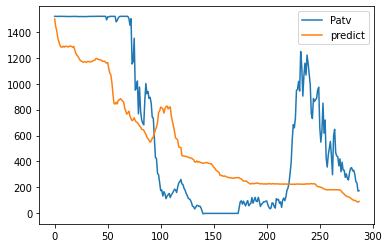

In [29]:
turbid = 1
predict_turb1 = [i[turbid-1] for i in predict_final]

check_data = test_data[(test_data['TurbID']==turbid)][['Patv']]
check_data['predict'] = predict_turb1

check_data.plot()